# Import các thư viện cần thiết

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [2]:
# Config GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Download, xử lý bộ dữ liệu MNIST

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

In [4]:
train_dataset = datasets.KMNIST(root='./kmnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.KMNIST(root='./kmnist_data/', train=False, transform=transform, download=False)

100%|██████████| 18165135/18165135 [00:11<00:00, 1579011.34it/s]


Extracting ./kmnist_data/KMNIST/raw/train-images-idx3-ubyte.gz to ./kmnist_data/KMNIST/raw



100%|██████████| 29497/29497 [00:00<00:00, 339238.83it/s]


Extracting ./kmnist_data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./kmnist_data/KMNIST/raw



100%|██████████| 3041136/3041136 [00:02<00:00, 1420182.84it/s]


Extracting ./kmnist_data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./kmnist_data/KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 9422920.79it/s]

Extracting ./kmnist_data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./kmnist_data/KMNIST/raw



In [5]:
batch_size = 100

In [6]:
# Data Loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Visualize samples thực từ dataset

In [7]:
img, label = train_dataset[0]
print('Label: ', label)
print(img[:,10:15,10:15])

Label:  8
tensor([[[-1.0000, -0.8745,  0.6235,  0.9765, -0.3412],
         [-1.0000,  0.0431,  1.0000,  0.1608, -1.0000],
         [-0.1765,  0.9765,  0.7255, -0.8667, -1.0000],
         [ 0.9294,  0.9922, -0.3804, -1.0000, -1.0000],
         [ 1.0000,  0.4588, -0.9843, -1.0000, -1.0000]]])


Label: 8


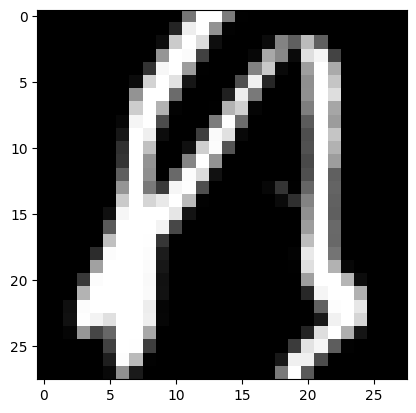

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

# Xây dựng mô hình Generator

In [9]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

# Xây dựng mô hình Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [11]:
# Khởi tạo input z (random noise) có chiều là 100
z_dim = 100

In [12]:
# Tính chiều của mỗi ảnh trong tập MNIST 28x28=784
kmnist_dim = train_dataset.data.size(1) * train_dataset.data.size(2)
kmnist_dim

784

In [13]:
#  Khởi tạo Generator, Discriminator network
G = Generator(g_input_dim = z_dim, g_output_dim = kmnist_dim).to(device)
D = Discriminator(kmnist_dim).to(device)

# Loss function và tham số cho quá trình training

In [14]:
criterion = nn.BCELoss()

# optimizer
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [15]:
print(G)
print(D)

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)


In [16]:
def discriminator_train(x):

    D.zero_grad()

    # train discriminator on real data
    x_real, y_real = x.view(-1, kmnist_dim), torch.ones(batch_size, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake data
    z = Variable(torch.randn(batch_size, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(batch_size, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
    
    # calculate accuracy
    D_real_accuracy = torch.divide(torch.sum(D_real_score > 0.5).float(), x_real.size(0))
    D_fake_accuracy = torch.divide(torch.sum(D_fake_score < 0.5).float(), x_real.size(0))

    return D_loss.data.item(), D_real_accuracy.item(), D_fake_accuracy.item()

In [17]:
def generator_train(x):
    G.zero_grad()

    z = Variable(torch.randn(batch_size, z_dim).to(device))
    y = Variable(torch.ones(batch_size, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()

#Training

In [18]:
epoch_D_losses, epoch_G_losses, epoch_D_real_accuracies, epoch_D_fake_accuracies = [], [], [], []

In [19]:
n_epoch = 100

for epoch in range(1, n_epoch + 1):
    D_losses, G_losses, D_real_accuracies, D_fake_accuracies = [], [], [], []
    
    for batch_idx, (x, _) in enumerate(train_loader):
        # Discriminator training trước, Generator training sau
        D_loss, D_real_accuracy, D_fake_accuracy = discriminator_train(x)
        G_loss = generator_train(x)

        D_losses.append(D_loss)
        G_losses.append(G_loss)
        D_real_accuracies.append(D_real_accuracy)
        D_fake_accuracies.append(D_fake_accuracy)
    
    epoch_D_losses.append(torch.mean(torch.FloatTensor(D_losses)))
    epoch_G_losses.append(torch.mean(torch.FloatTensor(G_losses)))
    epoch_D_real_accuracies.append(torch.mean(torch.FloatTensor(D_real_accuracies)))
    epoch_D_fake_accuracies.append(torch.mean(torch.FloatTensor(D_fake_accuracies)))

    print('[%d/%d]: Discriminator loss: %.3f, Generator loss: %.3f, Real accuracy: %.3f, Fake accuracy: %.3f' % (
        epoch, n_epoch, epoch_D_losses[-1], epoch_G_losses[-1], epoch_D_real_accuracies[-1], epoch_D_fake_accuracies[-1]))
    
    if epoch % 10 == 0:     
        torch.save(G.state_dict(), 'G.ckpt')
        torch.save(D.state_dict(), 'D.ckpt')
        print("Checkpoint saved!")

[1/100]: Discriminator loss: 1.197, Generator loss: 1.412, Real accuracy: 0.800, Fake accuracy: 0.574
[2/100]: Discriminator loss: 0.788, Generator loss: 3.588, Real accuracy: 0.858, Fake accuracy: 0.782
[3/100]: Discriminator loss: 0.841, Generator loss: 2.396, Real accuracy: 0.804, Fake accuracy: 0.824
[4/100]: Discriminator loss: 0.455, Generator loss: 3.181, Real accuracy: 0.897, Fake accuracy: 0.935
[5/100]: Discriminator loss: 0.465, Generator loss: 3.217, Real accuracy: 0.890, Fake accuracy: 0.933
[6/100]: Discriminator loss: 0.484, Generator loss: 3.095, Real accuracy: 0.881, Fake accuracy: 0.932
[7/100]: Discriminator loss: 0.403, Generator loss: 3.415, Real accuracy: 0.900, Fake accuracy: 0.950
[8/100]: Discriminator loss: 0.400, Generator loss: 3.423, Real accuracy: 0.898, Fake accuracy: 0.949
[9/100]: Discriminator loss: 0.402, Generator loss: 3.346, Real accuracy: 0.896, Fake accuracy: 0.950
[10/100]: Discriminator loss: 0.444, Generator loss: 3.315, Real accuracy: 0.887, 

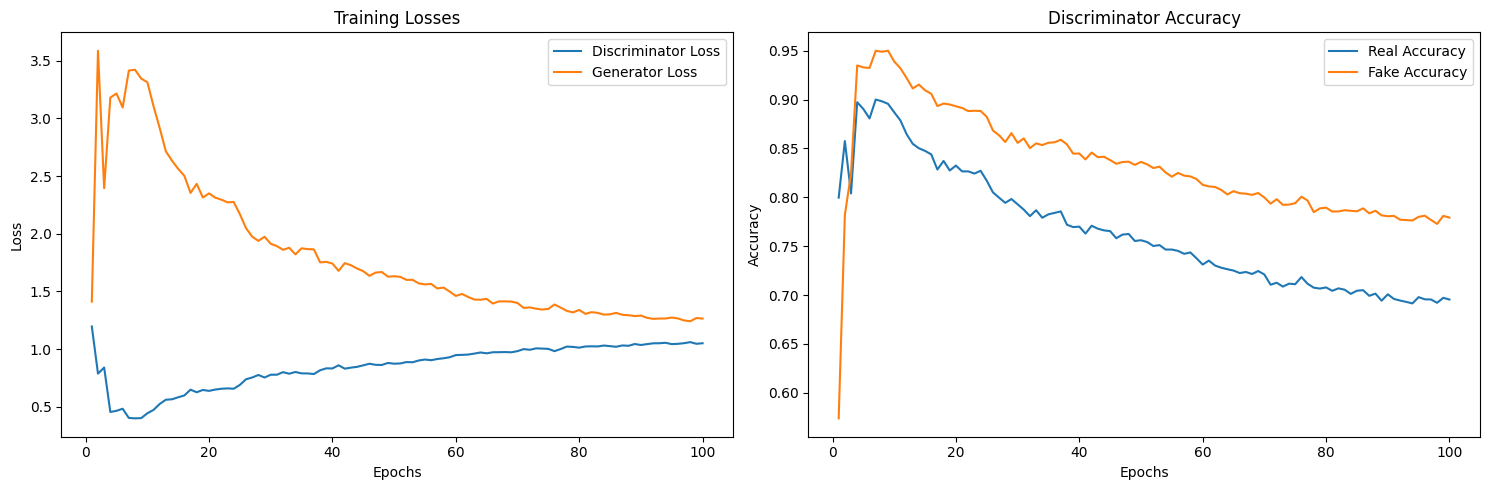

In [20]:
# Plot Training Loss and Discriminator Accuracy
plt.figure(figsize=(15, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, 101), epoch_D_losses, label='Discriminator Loss')
plt.plot(range(1, 101), epoch_G_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, 101), epoch_D_real_accuracies, label='Real Accuracy')
plt.plot(range(1, 101), epoch_D_fake_accuracies, label='Fake Accuracy')
plt.title('Discriminator Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plots
plt.show()

### Nhận xét:
- Bắt đầu 10 epoch đầu, Discriminator Loss giảm mạnh, Generator Loss tăng mạnh, sau đó xu hướng ngược lại, cả 2 dần hội tụ lại gần nhau sau 100 vòng lặp => có thể train tiếp
- Trong 10 vòng đầu Accuracy cả real và fake đều tăng mạnh, sau lại giảm dần cho tới tới gần ~0.7 cho real và ~0.8 cho fake =>  Discriminator trở nên khó khăn hơn trong việc phân biệt giữa ảnh thật và giả và có lẽ Generator đang tạo ra ảnh giả có tỷ lệ đánh lừa  Discriminator
- Qua mỗi epoch tất cả loss và acc đều dao động lên xuống => Discriminator và Generator đều đang học
- Thử mẫu generator bên dưới cho thấy hình giả dù chất lượng không cao nhưng mắt thường thấy đã có kết quả cơ bản => mô hình đang học hiệu quả

=> Tiếp tục train

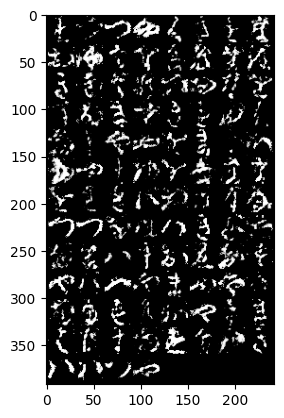

In [21]:
with torch.no_grad():
    test_1 = Variable(torch.randn(batch_size, z_dim).to(device))
    generated = G(test_1)

    save_image(generated.view(generated.size(0), 1, 28, 28), './sample_100' + '.png')
#Visualize kết quả từ mạng Generator sau quá trình training
plt.imshow(plt.imread('./sample_100.png'))

In [22]:
n_epoch = 100

for epoch in range(101, n_epoch + 101):
    D_losses, G_losses, D_real_accuracies, D_fake_accuracies = [], [], [], []
    
    for batch_idx, (x, _) in enumerate(train_loader):
        # Discriminator training trước, Generator training sau
        D_loss, D_real_accuracy, D_fake_accuracy = discriminator_train(x)
        G_loss = generator_train(x)

        D_losses.append(D_loss)
        G_losses.append(G_loss)
        D_real_accuracies.append(D_real_accuracy)
        D_fake_accuracies.append(D_fake_accuracy)
    
    epoch_D_losses.append(torch.mean(torch.FloatTensor(D_losses)))
    epoch_G_losses.append(torch.mean(torch.FloatTensor(G_losses)))
    epoch_D_real_accuracies.append(torch.mean(torch.FloatTensor(D_real_accuracies)))
    epoch_D_fake_accuracies.append(torch.mean(torch.FloatTensor(D_fake_accuracies)))

    print('[%d/%d]: Discriminator loss: %.3f, Generator loss: %.3f, Real accuracy: %.3f, Fake accuracy: %.3f' % (
        epoch, 100 + n_epoch, epoch_D_losses[-1], epoch_G_losses[-1], epoch_D_real_accuracies[-1], epoch_D_fake_accuracies[-1]))
    
    if epoch % 10 == 0:     
        torch.save(G.state_dict(), 'G.ckpt')
        torch.save(D.state_dict(), 'D.ckpt')
        print("Checkpoint saved!")

[101/200]: Discriminator loss: 1.045, Generator loss: 1.275, Real accuracy: 0.696, Fake accuracy: 0.780
[102/200]: Discriminator loss: 1.047, Generator loss: 1.266, Real accuracy: 0.695, Fake accuracy: 0.780
[103/200]: Discriminator loss: 1.061, Generator loss: 1.243, Real accuracy: 0.689, Fake accuracy: 0.775
[104/200]: Discriminator loss: 1.062, Generator loss: 1.239, Real accuracy: 0.688, Fake accuracy: 0.775
[105/200]: Discriminator loss: 1.065, Generator loss: 1.236, Real accuracy: 0.689, Fake accuracy: 0.774
[106/200]: Discriminator loss: 1.060, Generator loss: 1.247, Real accuracy: 0.692, Fake accuracy: 0.776
[107/200]: Discriminator loss: 1.057, Generator loss: 1.243, Real accuracy: 0.689, Fake accuracy: 0.777
[108/200]: Discriminator loss: 1.053, Generator loss: 1.260, Real accuracy: 0.694, Fake accuracy: 0.779
[109/200]: Discriminator loss: 1.063, Generator loss: 1.237, Real accuracy: 0.687, Fake accuracy: 0.776
[110/200]: Discriminator loss: 1.075, Generator loss: 1.215, Rea

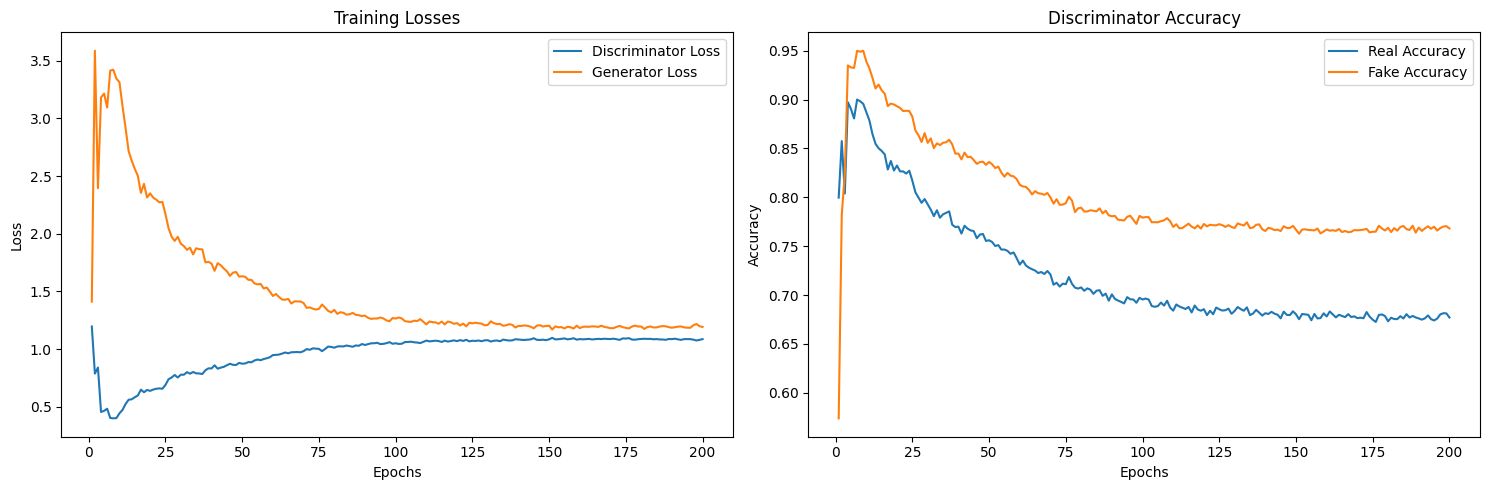

In [23]:
# Plot Training Loss and Discriminator Accuracy
plt.figure(figsize=(15, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, 201), epoch_D_losses, label='Discriminator Loss')
plt.plot(range(1, 201), epoch_G_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, 201), epoch_D_real_accuracies, label='Real Accuracy')
plt.plot(range(1, 201), epoch_D_fake_accuracies, label='Fake Accuracy')
plt.title('Discriminator Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plots
plt.show()

### Nhận xét:
Từ 100-200 epoch, cả 2 mô hình đang ổn định:
- Discriminator Loss và Generator Loss đang song song và tụ lại gần nhau, Real accuracy và fake accuracy giảm dần và dần ổn định ở ~0.67 cho real và ~0.77 cho fake
- Cả loss và accuracy điều dao động lên xuống => Discriminator và Generator vẫn đang đấu tranh
=> Mô hình khá ổn định
- Thử ảnh tạo giả từ G, mắt thường có thể thấy có tiến bộ nhưng chất lượng vẫn chưa cao => generator vẫn đang học và còn đang tiến bộ

=> Tiếp tục train

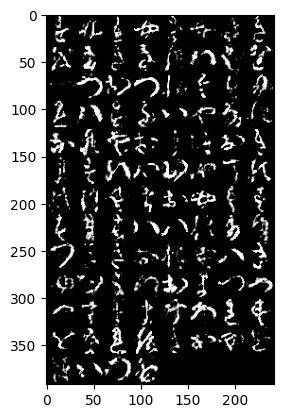

In [24]:
with torch.no_grad():
    test_2 = Variable(torch.randn(batch_size, z_dim).to(device))
    generated = G(test_2)

    save_image(generated.view(generated.size(0), 1, 28, 28), './sample_200' + '.png')
#Visualize kết quả từ mạng Generator sau 200 epoch
plt.imshow(plt.imread('./sample_200.png'))

In [25]:
n_epoch = 200

for epoch in range(201, n_epoch + 201):
    D_losses, G_losses, D_real_accuracies, D_fake_accuracies = [], [], [], []
    
    for batch_idx, (x, _) in enumerate(train_loader):
        # Discriminator training trước, Generator training sau
        D_loss, D_real_accuracy, D_fake_accuracy = discriminator_train(x)
        G_loss = generator_train(x)

        D_losses.append(D_loss)
        G_losses.append(G_loss)
        D_real_accuracies.append(D_real_accuracy)
        D_fake_accuracies.append(D_fake_accuracy)
    
    epoch_D_losses.append(torch.mean(torch.FloatTensor(D_losses)))
    epoch_G_losses.append(torch.mean(torch.FloatTensor(G_losses)))
    epoch_D_real_accuracies.append(torch.mean(torch.FloatTensor(D_real_accuracies)))
    epoch_D_fake_accuracies.append(torch.mean(torch.FloatTensor(D_fake_accuracies)))

    print('[%d/%d]: Discriminator loss: %.3f, Generator loss: %.3f, Real accuracy: %.3f, Fake accuracy: %.3f' % (
        epoch, 200 + n_epoch, epoch_D_losses[-1], epoch_G_losses[-1], epoch_D_real_accuracies[-1], epoch_D_fake_accuracies[-1]))
    
    if epoch % 10 == 0:     
        torch.save(G.state_dict(), 'G.ckpt')
        torch.save(D.state_dict(), 'D.ckpt')
        print("Checkpoint saved!")

[201/400]: Discriminator loss: 1.081, Generator loss: 1.205, Real accuracy: 0.681, Fake accuracy: 0.768
[202/400]: Discriminator loss: 1.089, Generator loss: 1.186, Real accuracy: 0.677, Fake accuracy: 0.767
[203/400]: Discriminator loss: 1.092, Generator loss: 1.190, Real accuracy: 0.677, Fake accuracy: 0.767
[204/400]: Discriminator loss: 1.092, Generator loss: 1.180, Real accuracy: 0.674, Fake accuracy: 0.765
[205/400]: Discriminator loss: 1.087, Generator loss: 1.194, Real accuracy: 0.676, Fake accuracy: 0.768
[206/400]: Discriminator loss: 1.078, Generator loss: 1.207, Real accuracy: 0.680, Fake accuracy: 0.769
[207/400]: Discriminator loss: 1.083, Generator loss: 1.203, Real accuracy: 0.678, Fake accuracy: 0.767
[208/400]: Discriminator loss: 1.081, Generator loss: 1.193, Real accuracy: 0.680, Fake accuracy: 0.771
[209/400]: Discriminator loss: 1.080, Generator loss: 1.197, Real accuracy: 0.677, Fake accuracy: 0.771
[210/400]: Discriminator loss: 1.084, Generator loss: 1.198, Rea

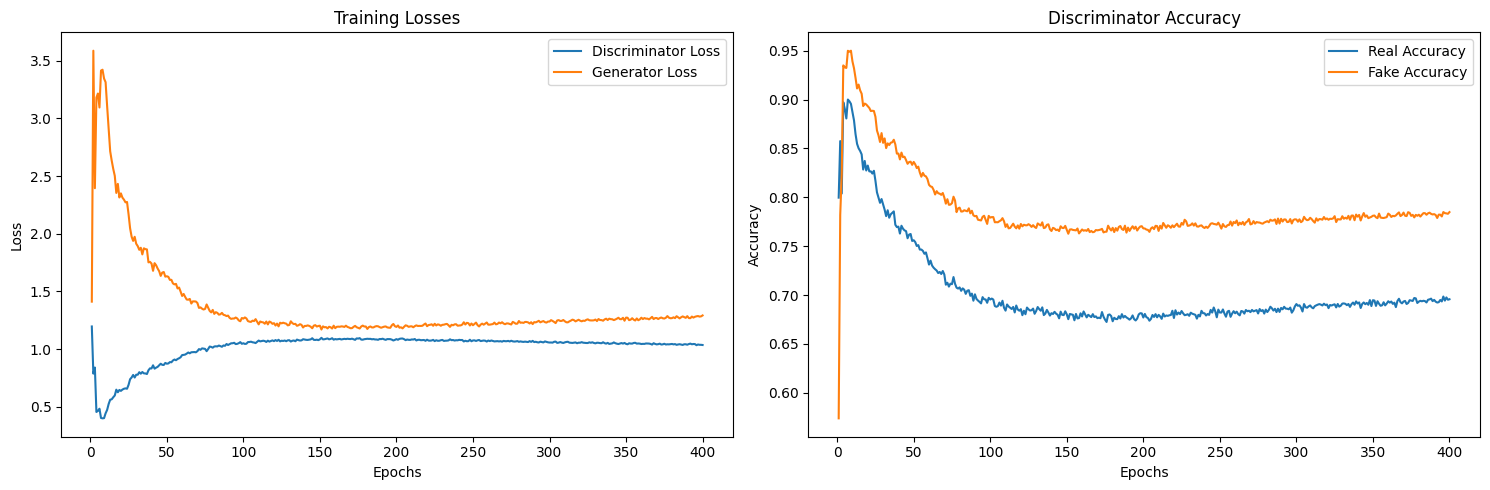

In [26]:
# Plot Training Loss and Discriminator Accuracy
plt.figure(figsize=(15, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, 401), epoch_D_losses, label='Discriminator Loss')
plt.plot(range(1, 401), epoch_G_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, 401), epoch_D_real_accuracies, label='Real Accuracy')
plt.plot(range(1, 401), epoch_D_fake_accuracies, label='Fake Accuracy')
plt.title('Discriminator Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plots
plt.show()

### Nhận xét:
- Từ trên 200 epoch đến 400 epoch Discriminator Loss và Generator Loss dần tản ra, acc bắt đầu tăng dần, Discriminator Loss tương đối ổn định => mô hình hơi mất cân đối
- Hình ảnh giả tạo ra bên dưới chất lượng có đều tăng trưởng

=> Thay đổi lr bằng scheduler để tune mô hình

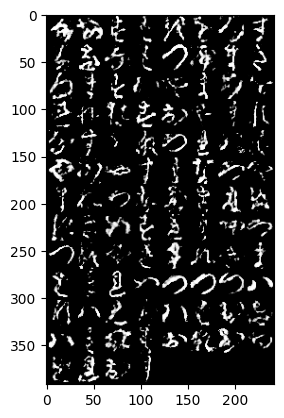

In [27]:
with torch.no_grad():
    test_3 = Variable(torch.randn(100, z_dim).to(device))
    generated = G(test_3)

    save_image(generated.view(generated.size(0), 1, 28, 28), './sample_400' + '.png')
    #Visualize kết quả từ mạng Generator sau 400 epoch
plt.imshow(plt.imread('./sample_400.png'))

In [28]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Khởi tạo scheduler
scheduler_G = ReduceLROnPlateau(G_optimizer, mode='min', factor=0.2, patience=5, verbose=True)
scheduler_D = ReduceLROnPlateau(D_optimizer, mode='min', factor=0.2, patience=5, verbose=True)

In [29]:
n_epoch = 100

for epoch in range(401, n_epoch + 401):
    D_losses, G_losses, D_real_accuracies, D_fake_accuracies = [], [], [], []
    
    for batch_idx, (x, _) in enumerate(train_loader):
        # Discriminator training trước, Generator training sau
        D_loss, D_real_accuracy, D_fake_accuracy = discriminator_train(x)
        G_loss = generator_train(x)

        D_losses.append(D_loss)
        G_losses.append(G_loss)
        D_real_accuracies.append(D_real_accuracy)
        D_fake_accuracies.append(D_fake_accuracy)
    
    epoch_D_losses.append(torch.mean(torch.FloatTensor(D_losses)))
    epoch_G_losses.append(torch.mean(torch.FloatTensor(G_losses)))
    epoch_D_real_accuracies.append(torch.mean(torch.FloatTensor(D_real_accuracies)))
    epoch_D_fake_accuracies.append(torch.mean(torch.FloatTensor(D_fake_accuracies)))

    print('[%d/%d]: Discriminator loss: %.3f, Generator loss: %.3f, Real accuracy: %.3f, Fake accuracy: %.3f' % (
        epoch, 400 + n_epoch, epoch_D_losses[-1], epoch_G_losses[-1], epoch_D_real_accuracies[-1], epoch_D_fake_accuracies[-1]))
    
    if epoch % 10 == 0:     
        torch.save(G.state_dict(), 'G.ckpt')
        torch.save(D.state_dict(), 'D.ckpt')
        print("Checkpoint saved!")
        
    # Cập nhật learning rate
    scheduler_G.step(epoch_D_losses[-1])
    scheduler_D.step(epoch_G_losses[-1])

[401/500]: Discriminator loss: 1.038, Generator loss: 1.290, Real accuracy: 0.697, Fake accuracy: 0.783
[402/500]: Discriminator loss: 1.042, Generator loss: 1.272, Real accuracy: 0.693, Fake accuracy: 0.781
[403/500]: Discriminator loss: 1.038, Generator loss: 1.280, Real accuracy: 0.696, Fake accuracy: 0.783
[404/500]: Discriminator loss: 1.036, Generator loss: 1.285, Real accuracy: 0.696, Fake accuracy: 0.783
[405/500]: Discriminator loss: 1.038, Generator loss: 1.289, Real accuracy: 0.698, Fake accuracy: 0.784
[406/500]: Discriminator loss: 1.033, Generator loss: 1.283, Real accuracy: 0.699, Fake accuracy: 0.785
[407/500]: Discriminator loss: 1.033, Generator loss: 1.300, Real accuracy: 0.699, Fake accuracy: 0.784
[408/500]: Discriminator loss: 1.037, Generator loss: 1.280, Real accuracy: 0.698, Fake accuracy: 0.784
Epoch 00008: reducing learning rate of group 0 to 4.0000e-05.
[409/500]: Discriminator loss: 1.094, Generator loss: 1.150, Real accuracy: 0.670, Fake accuracy: 0.768
[4

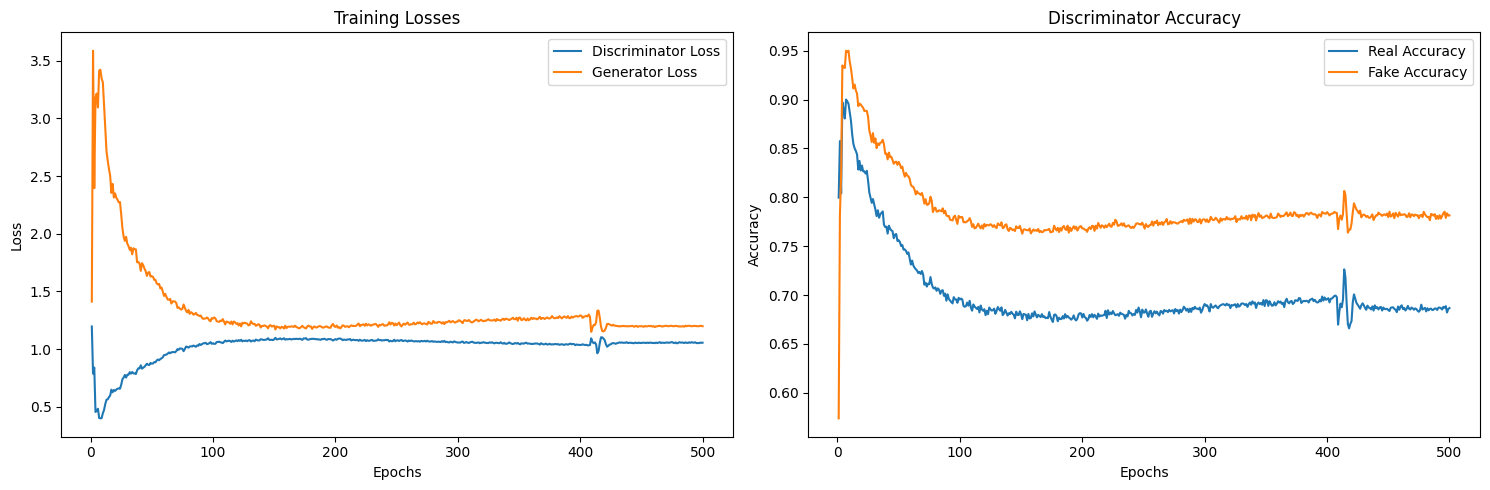

In [30]:
# Plot Training Loss and Discriminator Accuracy
plt.figure(figsize=(15, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, 501), epoch_D_losses, label='Discriminator Loss')
plt.plot(range(1, 501), epoch_G_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, 501), epoch_D_real_accuracies, label='Real Accuracy')
plt.plot(range(1, 501), epoch_D_fake_accuracies, label='Fake Accuracy')
plt.title('Discriminator Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plots
plt.show()

### Nhận xét:
- Discriminator Loss và Generator Loss sau khi đổi lr thì có vài lần thay đổi lên xuống biến động mạnh hơn các epoch trước, sau đó dần dần ổn định, acc cũng thay đổi theo tần suất của loss, mô hình dường như đang song song ổn định chạy
- Hình giả mắt thường thấy được có tiến bộ nhưng vẫn thấy 1 vài ký tự rất giả => generator cần học thêm
- 2 loss vẫn đang ổn định ~ 1.1-1.2 => 2 mô hình vẫn đang học có hiệu quả

=> Tiếp tục train với scheduler, save thêm check point ở best Generator Loss để dự phòng

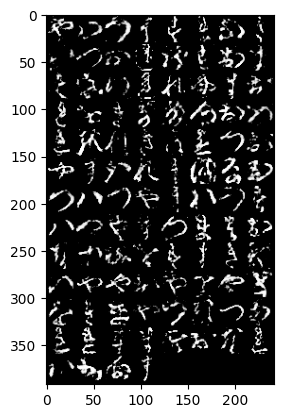

In [31]:
with torch.no_grad():
    test_4 = Variable(torch.randn(100, z_dim).to(device))
    generated = G(test_4)

    save_image(generated.view(generated.size(0), 1, 28, 28), './sample_500' + '.png')
    #Visualize kết quả từ mạng Generator sau 1000 epoch
plt.imshow(plt.imread('./sample_500.png'))

In [33]:
n_epoch = 500
best_G_loss = float('inf')

for epoch in range(501, n_epoch + 501):
    D_losses, G_losses, D_real_accuracies, D_fake_accuracies = [], [], [], []
    
    for batch_idx, (x, _) in enumerate(train_loader):
        # Discriminator training trước, Generator training sau
        D_loss, D_real_accuracy, D_fake_accuracy = discriminator_train(x)
        G_loss = generator_train(x)

        D_losses.append(D_loss)
        G_losses.append(G_loss)
        D_real_accuracies.append(D_real_accuracy)
        D_fake_accuracies.append(D_fake_accuracy)
    
    epoch_D_losses.append(torch.mean(torch.FloatTensor(D_losses)))
    epoch_G_losses.append(torch.mean(torch.FloatTensor(G_losses)))
    epoch_D_real_accuracies.append(torch.mean(torch.FloatTensor(D_real_accuracies)))
    epoch_D_fake_accuracies.append(torch.mean(torch.FloatTensor(D_fake_accuracies)))

    print('[%d/%d]: Discriminator loss: %.3f, Generator loss: %.3f, Real accuracy: %.3f, Fake accuracy: %.3f' % (
        epoch, 500 + n_epoch, epoch_D_losses[-1], epoch_G_losses[-1], epoch_D_real_accuracies[-1], epoch_D_fake_accuracies[-1]))
    
    if epoch % 10 == 0:     
        torch.save(G.state_dict(), 'G.ckpt')
        torch.save(D.state_dict(), 'D.ckpt')
        print("Checkpoint saved!")
        
    if epoch_G_losses[-1] < best_G_loss:
        best_G_loss = epoch_G_losses[-1]
        torch.save(G.state_dict(), 'best_G.ckpt')
        torch.save(D.state_dict(), 'best_D.ckpt')
        print("Best Generator checkpoint saved!")
        
    # Cập nhật learning rate
    scheduler_G.step(epoch_D_losses[-1])
    scheduler_D.step(epoch_G_losses[-1])

[501/1000]: Discriminator loss: 1.060, Generator loss: 1.198, Real accuracy: 0.684, Fake accuracy: 0.781
Best Generator checkpoint saved!
[502/1000]: Discriminator loss: 1.052, Generator loss: 1.196, Real accuracy: 0.689, Fake accuracy: 0.783
Best Generator checkpoint saved!
[503/1000]: Discriminator loss: 1.058, Generator loss: 1.200, Real accuracy: 0.684, Fake accuracy: 0.781
[504/1000]: Discriminator loss: 1.056, Generator loss: 1.201, Real accuracy: 0.687, Fake accuracy: 0.782
[505/1000]: Discriminator loss: 1.050, Generator loss: 1.201, Real accuracy: 0.688, Fake accuracy: 0.783
[506/1000]: Discriminator loss: 1.054, Generator loss: 1.198, Real accuracy: 0.686, Fake accuracy: 0.785
[507/1000]: Discriminator loss: 1.055, Generator loss: 1.204, Real accuracy: 0.686, Fake accuracy: 0.782
[508/1000]: Discriminator loss: 1.057, Generator loss: 1.201, Real accuracy: 0.684, Fake accuracy: 0.781
[509/1000]: Discriminator loss: 1.056, Generator loss: 1.203, Real accuracy: 0.689, Fake accur

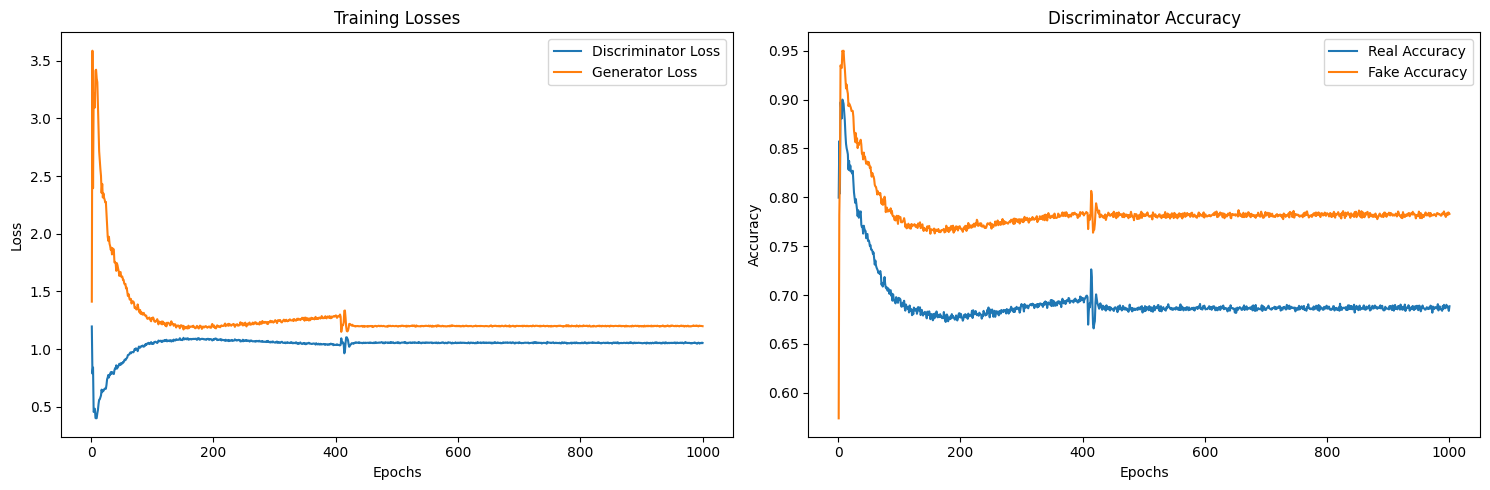

In [34]:
# Plot Training Loss and Discriminator Accuracy
plt.figure(figsize=(15, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, 1001), epoch_D_losses, label='Discriminator Loss')
plt.plot(range(1, 1001), epoch_G_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, 1001), epoch_D_real_accuracies, label='Real Accuracy')
plt.plot(range(1, 1001), epoch_D_fake_accuracies, label='Fake Accuracy')
plt.title('Discriminator Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plots
plt.show()

### Nhận xét 500-1000 epoch:
- Mô hình xem như hoàn toàn ổn định và có xu hướng ổn định trong thời gian dài
- Hình giả không có tiến bộ mạnh
=> Cần tune thêm, mô hình cần cải tiến thêm.

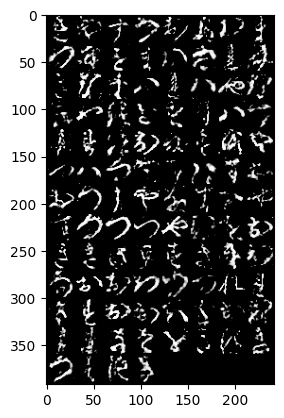

In [35]:
with torch.no_grad():
    test_4 = Variable(torch.randn(100, z_dim).to(device))
    generated = G(test_4)

    save_image(generated.view(generated.size(0), 1, 28, 28), './sample_1000' + '.png')
    #Visualize kết quả từ mạng Generator sau 1000 epoch
plt.imshow(plt.imread('./sample_1000.png'))

## Nhận xét:
- Mô hình GAN với Neural Network nhu cần tài nguyên gpu khá khiêm tốn
- Tốc độ train nhanh hơn so với mô hình sử dụng Convolutional Neural Network
- Cấu trúc mô hình cũng đơn giản hơn so với sử dụng CNN => dễ tune dễ code
- Mô hình còn chưa đủ thông minh để đạt được hiệu quả tốt, cần thêm huấn luyện và điều chỉnh thêm nữa

In [32]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

In [36]:
#Load checkpoint nếu bỏ qua bước trainning
G = Generator(g_input_dim = z_dim, g_output_dim = kmnist_dim)
G.load_state_dict(torch.load('G.ckpt'))
G.to(device)
G.eval()

D = Discriminator(d_input_dim = kmnist_dim)
D.load_state_dict(torch.load('D.ckpt'))
D.to(device)
D.eval()

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)